In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import Quandl
import numpy as np
import scipy as sp
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Time Series

Time series prediction or forecasting presents its own challenges which are different from machine-learning problems.  Like many other classes of problems, it also presents a number of special features which are common.

As we explain these, let's first define our time-series as

$$ \{X_t, t = \ldots, -1, 0, 1, \ldots\} \, . $$

In general, while we could use regression to make predictions, the goal of time series analysis is to take advantage of the temporal nature of the data to make more sophisticated models.  

Here are a few concepts related to time series.  We take $\varepsilon \sim N(0, \sigma^2)$ to be i.i.d. normal errors.  
1. **Stationarity**.  Informally, this means that the distribution of the $X_t$ is independent of time $t$.  Formally, a time-series is stationary if for all $k \ge 0$ and $t$, the following two $k$-tuples have the same distribution:
$$ (X_0,\ldots,X_k) \sim (X_t,\ldots,X_{t+k}) $$
1. **Drift**.  One reason a time-series might not be stationary is that it possess a drift.  For example, we know that prices tend to creep up with inflation.  Mathemtically, we might represent the (log) prices as
$$ X_t = \mu t + \varepsilon_t $$
1. **Seasonality**.  Another reason a time-series might not be stationary is that it posses a seasonal component.  For example, we know that the temperature increases in the summer and decreases in the winter.  A simple models of this might be
$$ X_t = \alpha \sin(\omega t) + \beta \cos(\omega t)$$

**Question**: why is this parameterization equivalent to the (perhaps more straightforward) parameterization $X_t = \alpha \sin(\omega t + \omega_0) + \varepsilon_t$?.  Why might the former be preferable?

For examples, we will use two different datasets, weather and oil prices. The weather data is available locally in the `projects/` subdirectory, and the oil data will be retrieved on-the-fly from Quandl.

In [3]:
temps = pd.read_csv("projects/timeseries-project/data/raw/temperatures.csv", 
                    index_col=0,
                    names=["Temperature"],
                    parse_dates=True,
                    date_parser=lambda u: pd.datetime.strptime(u, "%Y-%m-%d %H:%M:%S"))

In [4]:
ts = temps['Temperature'].asfreq('60Min', method='ffill')
temps['Temperature'] = ts
print temps[:3]

                     Temperature
2001-01-01 00:00:00           18
2001-01-01 01:00:00           18
2001-01-01 02:00:00           17


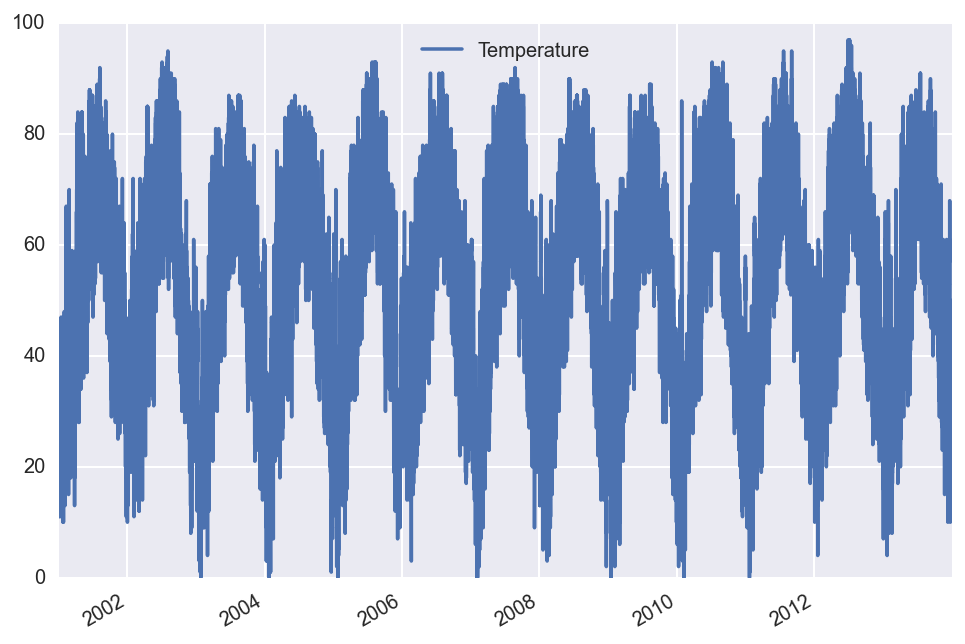

In [5]:
temps.plot()

In [6]:
# To really use the Quandl API, you should get an authtoken.  Limited usage doesn't require it.

authtoken = None
# authtoken = "your token here"


def get_quandl(what):
    """ 
    Wrapper around Quandl requests, using authtoken only if available
    """
    if authtoken:
        return Quandl.get(what, authtoken=authtoken)
    else:
        return Quandl.get(what)

In [7]:
oil = get_quandl("DOE/RWTC")

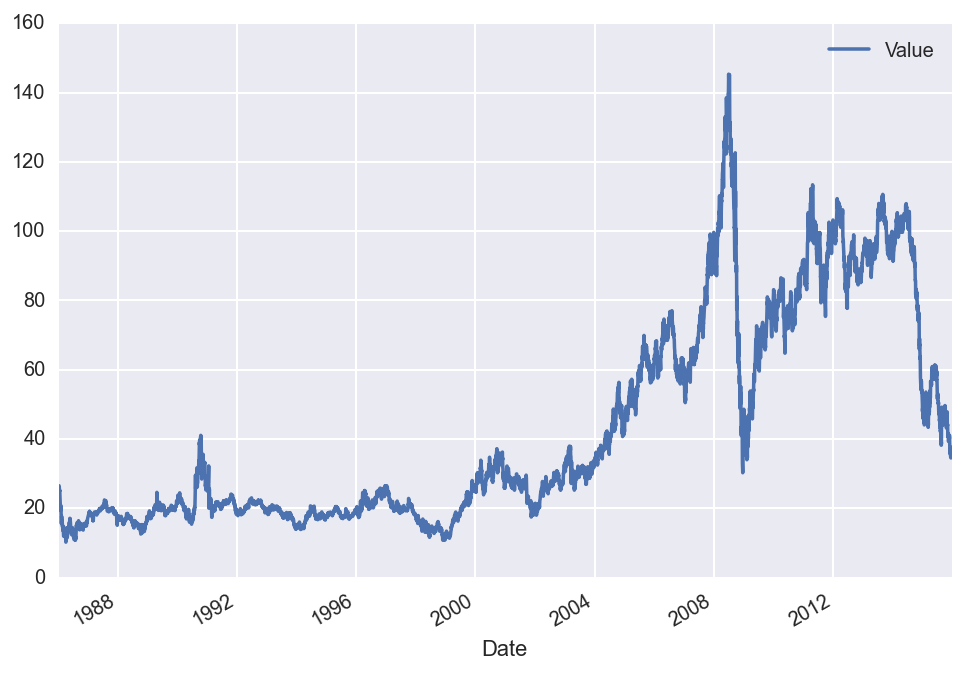

In [8]:
oil.plot()

In [9]:
oil['Julian'] = oil.index.to_julian_date()
oil = sm.add_constant(oil) # Add a constant field for the linear regression

## Trends in time series data
One way to improve time series models is to use the idea of trends. We can consider the following cases:
- no trend (variation about the mean)
- seasonal trend (periodicity)
- long-term linear trend
- long-term nonlinear trend (eg. exponential)
- a combination of the above

Starting with long-term trends...

In [10]:
# We can actually train a simple exponential model using the log(value), then train further models on the error.
exponential_model = sklearn.linear_model.Ridge().fit( 
    X=oil[['Julian', 'const']], 
    y=np.log(oil['Value'])
)

exp_model_df = oil
exp_model_df['Exponential_Model'] = np.exp(exponential_model.predict(oil[['Julian', 'const']]))
exp_model_df['Log_Error_Exponential'] = np.log(oil['Value'] / oil['Exponential_Model'])

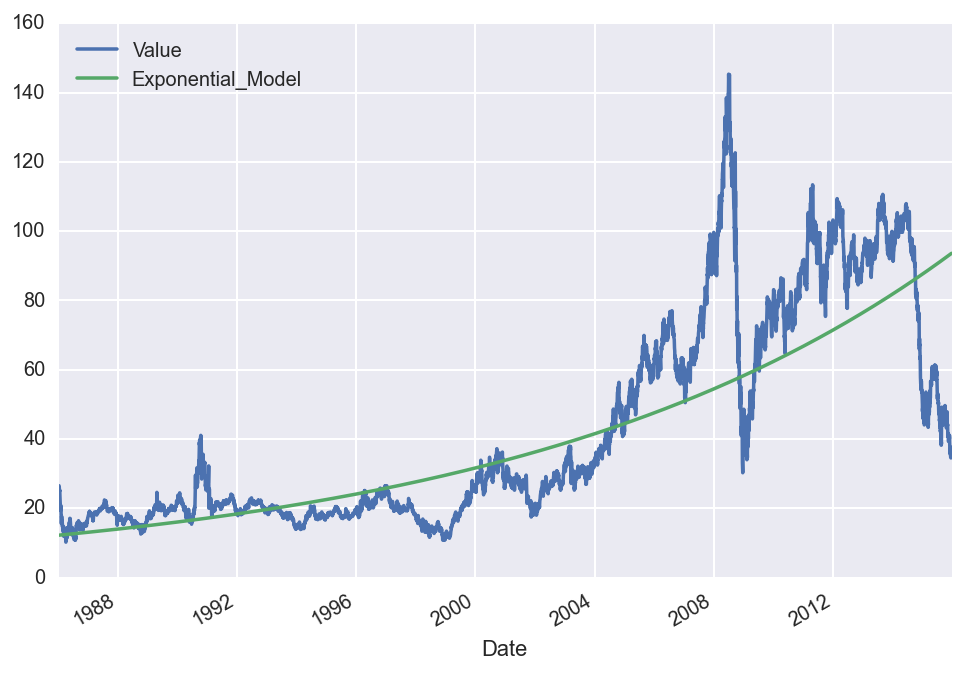

In [11]:
exp_model_df[['Value', 'Exponential_Model']].plot()

## Seasonality and autocorrelation

Sometimes values in the dataset are positively correlated with earlier values. Seasonality refers specifically to a periodic correlation in the data.  Sometimes we can spot seasonality by looking at the raw series, but a more rigorous approach is to use the *autocorrelation*.  For fixed $k$, define the autocovariance as

$$ \gamma_k = \mbox{Cov}(X_t, X_{t+k}) \, ,$$

and then define the autocorrelation as

$$ \rho_k = \frac{\gamma_k}{\gamma_0} \, .$$

If there is a cyclic pattern, we would expect both $\gamma_k$ and $\rho_k$ to exhibit periodicity.

**Questions:**
1. Both $\gamma_k$ and $\rho_k$ and the original series $X_t$ exhibit periodicity (if any existed in the first place).  Why do we prefer to examine the autocovariance?
1. How do $\gamma_k$ and $\rho_k$ scale with $X_k$?  Why might we prefer $\rho_k$ more than $\gamma_k$?

Pandas includes a function which will create an autocorrelation plot for any data series.  It includes lines showing the 95% (solid) and 99% (dashed) confidence levels of the zero-correlation hypothesis.

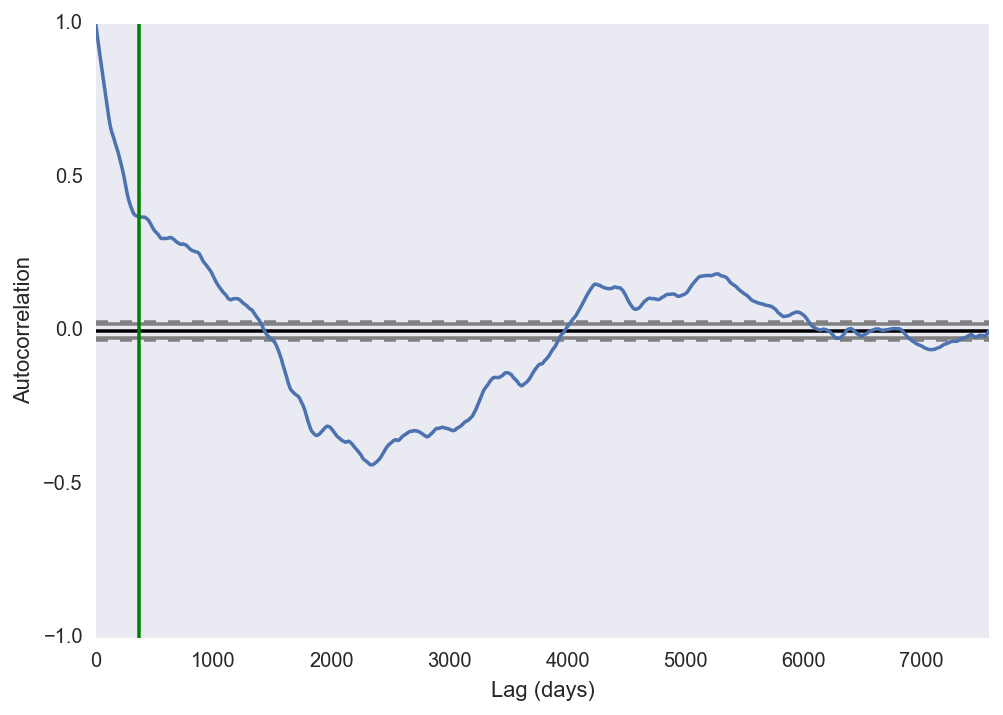

In [12]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(oil['Log_Error_Exponential'])
plt.xlabel('Lag (days)')
plt.axvline(365, color = 'green')

Here, we are looking at the autocorrelation of the residuals, after removing the exponential fit.  This lets us look for seasonality on top of the base drift. The autocorrelation is near 1 for short lags, so using the last few day's values in a model is likely to be useful.  There are no periodic peaks, suggesting that there were no seasonal effects. This might be surprising, given that the demand for oil has obvious seasonality.  The lack of seasonality in the price suggests that the oil futures market is working.

In contrast, we can clearly see seasonal effects in the temperature data:

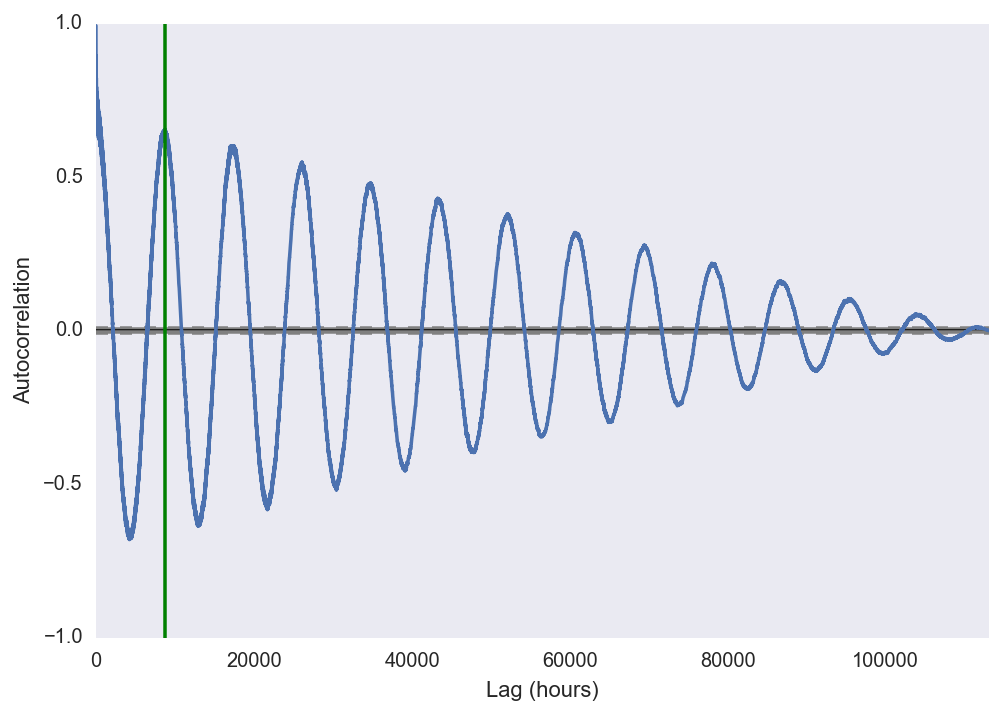

In [13]:
autocorrelation_plot(temps.Temperature)
plt.xlabel('Lag (hours)')
plt.axvline(365*24, color = 'green')

### Fourier Analysis

Any periodic signal can be represented as the sum of a number of sine waves with varying amplitude, phase, and frequency.  A time series can be convered into its frequency components with the mathematical tool known as the *Fourier transform*.  As we are dealing with sampled data, we must use the discrete version.  The common algorithm for computing discrete transforms in the *fast Fourier transform*, usually abbreviated *FFT*.

The output of a FFT can be thought of as a representation of all the frequency components of your data. In some sense it is a histogram with each “frequency bin” corresponding to a particular frequency in your signal. Each frequency component has both an amplitude and phase, and is represented as a complex number.  Generally, we care only about the amplitude, given by the modulus of that complex term.  As we are dealing with discrete data, the signal is bounded, and interpretation of the axes requires some consideration.

For our purposes, it's enough to know that any strong signals such as peaks in the frequency domain represent some periodic (sinusoidal) behavior in the time domain. You can then go through the process of determining the wavelength (periodicity) based on how the FFT was taken.

In [ ]:
from scipy import fftpack

fft = fftpack.fft(temps.Temperature - temps.Temperature.mean())
plt.plot(np.abs(fft))
plt.title("FFT of temperature data")
plt.xlabel('# Cycles in full window of data (~13 years)')

Note that we subtract the mean before computing the FFT.  Otherwise, there would be a large zero-frequency component.

The x-axis is showing frequency.  Low frequencies, corresponding to long times, are on the left; high freqencies and short times are on the right.  The lowest non-zero frequency measured has a single cycle over the full 13-year period, corresponding to a frequency of $1/13\, y^{-1}$.  The highest frequency is that of the sampling, $1\, h^{-1}$.

The discrete Fourier transform of real data is symmetric about the center of its frequency range.  Due to the problem of *aliasing*, it cannot distinguish signals with a frequency above half its sampling frequency from those below.  This limiting frequency is called the *Nyquist frequency*, and the results of a FFT for frequencies above it should be ignored.

In [ ]:
from scipy import fftpack

fft = fftpack.fft(temps.Temperature-temps.Temperature.mean())
plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (Low Frequencies zoom)")
plt.xlim([0,5])
plt.xlabel('Frequency ($y^{-1}$)')

**Question:** Is the above showing the yearly or daily seasonality?

In [ ]:
daily_cycles_in_13_years = 13*365

plt.plot(1./13 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of temperature data (High Frequencies zoom)")
plt.ylim([0,150000])
plt.xlim([365 - 60, 365 + 60])
plt.xlabel('Frequency ($y^{-1}$)')
plt.axvline(365, color = 'green')

**Question:** What do you expect the FFT of the oil data to look like?

In [ ]:
fft = fftpack.fft(oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2010)])
plt.plot(np.abs(fft))
plt.ylim([0, 700])
plt.xlim([0, 400])
plt.title('FFT of Log Error in Oil Prices')
plt.xlabel('# Cycles in window of data (~17 years)')

There are two ways to handle seasonality.  Seasonality features are nice because they are good at projecting arbitrarily far into the future.

1. The simplest (and perhaps most robust) is to have a set of indicator variables for each month.

  **Question**: Should month be a continuous or categorical variable?

1. Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be
$$ y_t = k \sin\left( \frac{t - t_0}{T} \right) + \epsilon$$
where $k$ and $t_0$ are parameters to be learned and $T$ is one year for seasonal variation.  While this is linear in $k$, it is not linear in $t_0$.  However, we know from Fourier analysis, that the above is equivalent to 
$$ y_t = A \sin\left( \frac{t}{T} \right) + B \cos\left( \frac{t}{T} \right) + \epsilon$$
which is linear in $A$ and $B$.  This can be solved using a linear regression.

**Question:** Does it always make sense to combine seasonal frequencies additively? When would it not?

**Exercise**: Graph temperature as a function of time on both the annual and daily levels.  Build transformers that generate these features and use `pipeline.Pipeline` to concatonate them with a regressor like `linear_model.LinearRegressor`.  How do they perform?

## Moving Average and Autoregression

Having dealt with long term and periodic trends, let's consider the case where there are no trends. Often in time series, the "last data point", is a good model for the next value. We can usually gain some predictive power by assuming that data points in the time series are closely correlated with recent points. Remember the leftmost part of the autocorrelation function? We're going to formalize that by estimating the value at time x as some function of the previous k values.

We can predict arbitrarily far into the future with this method, by substituting the moving average predictions in for values as necessary. For example, if we only knew the values up through time x, we would need to estimate Value[x + 1] before calculating Value[x + 2] = f(Value[x + 1], Value[x], Value[x - 1], ...).

There are many types of [moving average](http://en.wikipedia.org/wiki/Moving_average). Simple variations on this include [exponential moving averages](https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average) and [rolling window averages](https://en.wikipedia.org/wiki/Moving_average#Cumulative_moving_average). While these features might give more accurate data, they are only useful for short-term projections (as compared to seasonality and longer-term trends). As you'll see, they're also quite good for smoothing purposes. We will be computing the exponentially weighted moving average here:

$$E_t = \alpha X_t + (1-\alpha)E_{t-1}$$

Note that as the smoothing factor $\alpha$ increases, older observations are discounted faster. In Pandas, the ewma() method allows for specifying the decay as a function of $\alpha$ in three ways:
1. The center of mass (*com*), giving $\alpha = \frac{1}{1 + com}$
2. The *span*, giving $\alpha = \frac{2}{1 + span}$
3. The *halflife*, giving $\alpha = 1 - \exp{\frac{\log(0.5)}{halflife}}$

Let's pick up the oil price data using the residual after the exponential trend is removed. Since we know that something crazy happened in 2008 (financial meltdown) and something else crazy happened in 1992 (Iraq War), we'll restrict our analysis to between those two dates.

In [ ]:
from IPython.html.widgets import *

log_error = oil['Log_Error_Exponential'][(oil.index.year > 1992) & (oil.index.year < 2008)]

def update(span=100):
    pd.DataFrame({
        'log_error': log_error,
        'ewma': pd.ewma(log_error, span=span)
    }).plot()

In [ ]:
interact(update, span=(0,200,20))

**Exercise**: For seasonal time series such as weather, the most useful "last data points" tend to reflect the trends. Consider two different "last points", the first being the temperature in the last hour and the second being the temperature 24 hours ago.  Build these as features and see how they improve performance.
*Note:*
1.  These are features that should probably be generated on the entire dataset rather than separately on the training and validation sets (can you explain why?)
1.  Be careful in computing these to make sure you don't accidently have information about today's temperature in your correlates (this would be cheating!).

### Combining ideas

We've already demonstrated one way of combining ideas by training one model on the residual of another (usually higher bias) model. We can also combine ideas using Linear Regression on a variety of features.

Let's discuss time series cross-validation before we train the model.

## Cross-validation for time series
Cross validation is very different for time series than with other machine-learning problem classes.  In normal machine-learning, we select a random subset of data as a validation set to estimate accuracy of your measure.  In time series, we have to consider the problem that we are trying to solve is often to predict a value in the future.  Therefore, the validation data always has to occur *after* the training data.  As a simple example, consider that it would not be very useful to have a predictor of tomorrow's temperature that depended on the temperature the day after. In general:

- We cannot just pick data points at random, because there might be lagged indicators / seasonal effects / etc. that force us to work with contiguous blocks of time.  
- We cannot blindly chop by e.g., month or year without some thought: There could be seasonal effects so that Decembers are always different.  There could be systemic "regime changes" that mean that cutting at a given date is inappropriate, or known and time-limited effects that last a year (or fraction thereof).   For instance, the years 1991 and 2008 in this data set.
- We cannot have our testing set occur before our training set.

![ts cross-validation illustration](images/ts_xval.png)

We usually handle this by doing a **sliding-window validation method**.  That is, we train on the last $n$ data points and validate the prediction on the next $m$ data points, sliding the $n + m$ training / validation window in time.  In this way, we can estimate the parameters of our model.  To test the validity of the model, we might use a block of data at the end of our time series which is reserved for testing the model with the learned parameters.

Another common technique is to use [**forward chaining**](http://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection).

**Question:** What are the strengths and weaknesses of using a fixed vs. rolling window?

Another concern is whether the time series results are predictive.  In economics, we refer to this as the ergodicity assumption, that past behavior can inform future behavior.  Many wonder if past behavior in daily stock returns gives much predictive power for future behavior.

**Warning**: Feature generation is sometimes a little different for time-series.  Usually, feature generation on a set is only based on data in that training example (e.g. extracting the time of day of the temperature measurement).  In timeseries, we often want to use *lagged* data (the temperature an hour ago).  The easiest way to do this is to do the feature generation *before* making the training and validation split.

**Exercise**: Split the data into a training and validation set.  Use the last year of data for training.  Using the 'mean temperature' (`dummy.DummyRegressor`) as a baseline model.

## Example: Predicting Oil Prices

We will attempt to build a model to predict oil prices 3 months in the future.  A column of oild prices shifted by in time by 3 months will serve as our labels for testing and training.

In [ ]:
## Create a column with "true" (future) values
PERIOD_MONTH = 20
PREDICTION_LAG = 3 * PERIOD_MONTH

CUT_YEAR = 2008

# notice that the goal is our variable shifted by the desired period of time
oil['Actual'] = oil['Value'].shift(-PREDICTION_LAG)

In [ ]:
oil['Value'].head()

In [ ]:
oil['Value'].shift(-1).head()

In [ ]:
oil.head()

We build a model to predict the residuals of the exponential model three months out, from the last and current residuals, as well as 3-month rolling averages for the price and its derivative.

In [ ]:
### Cross validation -- simple model

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]

# Reporting function
def summarize_errors(test_me):
    error_pct = (test_me['Actual'] - test_me['Model']) / test_me['Actual']

    print error_pct.describe()
    error_pct.plot()
    plt.title('% error')
    plt.show()

    error_pct.hist(bins=100, normed=True, label = 'Counts')
    x = np.arange(-1, 1, 0.001)
    plt.plot(x, sp.stats.norm(loc=error_pct.mean(),
                              scale=error_pct.std()).pdf(x),
                              linewidth=3, color='red', label='Normal Dist')
    plt.title('Histogram of % errors')
    plt.legend()
    plt.show()

    print sklearn.metrics.mean_squared_error( test_me['Actual'], test_me['Model'] )

# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['LEE_1'] = frame['Log_Error_Exponential'].shift(1)
    feats['dLEE_avg'] = pd.rolling_mean(frame['Value'].diff(), window=3*PERIOD_MONTH)
    feats['vol_avg'] = pd.ewmvar(frame['Value'], span=3*PERIOD_MONTH)
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return sm.add_constant(feats)

feats = frame_to_feats(train).dropna(how='any')
X_train = feats.drop('Actual_LEE', axis=1).values
y_train = feats['Actual_LEE'].values
regress = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

# Predict
feats = frame_to_feats(test).dropna(how='any')
X_test = feats.drop('Actual_LEE', axis=1).values
y_test = feats['Actual_LEE'].values
feats['Predicted_LEE'] = regress.predict(X_test)

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Simple_Model'] = np.exp(test['Predicted_LEE']) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Simple_Model']].dropna(how='any') \
                                          .rename(columns={'Simple_Model': 'Model'})
summarize_errors(test_me)

For comparison, consider a benchmark model that uses the current price as its prediction for the future.  We beat this model, but not by much.  There's room for improvement.

In [ ]:
### Cross validation -- benchmark model

#Train/Test
train = oil[(oil.index.year < CUT_YEAR)].copy()
test = oil[(oil.index.year >= CUT_YEAR)].copy()

test['Benchmark_Model'] = oil['Value']
test_me = test[['Actual', 'Benchmark_Model']].dropna(how='any') \
                                             .rename(columns={"Benchmark_Model": "Model"})
summarize_errors(test_me)

**Exercise**: Build a temperature predictor using just these other features.  Try experimenting with non-linear models like random forests as well as linear ones.  While it may not be as effective, it can add signal when combined with the above models.  *Notes*:
1. Make sure you don't accidently give yourself access to concurrent data: you cannot use the wind direction this hour to predict the temperature, you have to use past wind direction information.
1. Try combining the signal using non-linear as well as linear techniques.  Is there a reason you might think that linear techniques work pretty well for aggregation of different signals?

## Using external data sources as features

So far, our features have all depended on the date and previous temperature.  However, we can add in other variables into our prediction. Ideally we'd like to find signal in additional data sources that accounts for some of the error; to try to conceptually explain sources of error or skews in the distribution of error; etc.  Here are examples of other data sources we might try:

  - Other financial indicators (e.g., interest rates, volatilities, related commodities)
  - Non-financial indicators (e.g., weather, indicators for weather patterns / wars, geopolitical data like gdelt).
  
We'll show the example of trying to use equities volatility data (in the form of the VIX index) -- note that this will not help. Can you do better?

In [ ]:
ng_fut = get_quandl("CHRIS/CME_NG1")
vix = get_quandl("YAHOO/INDEX_VIX")

oil['vix'] = vix['Adjusted Close']
oil['ng_fut'] = ng_fut['Settle']

In [ ]:
# Looking at linear correlations between new data and the stationary residual of the oil data
print oil['Log_Error_Exponential'].corr(oil['vix'])  # Our error term does correlate negatively with vix...
print oil['Log_Error_Exponential'].corr(oil['ng_fut'])

oil['vix'].plot()
plt.show()

oil['ng_fut'].plot()
plt.show()

In [ ]:
### Cross validation -- complex model -- notice that we have overfit!

#Train/Test
train = oil[oil.index.year < CUT_YEAR]
test = oil[oil.index.year >= CUT_YEAR]


# Train the regression
def frame_to_feats(frame):
    feats = pd.DataFrame()
    
    feats['LEE'] = frame['Log_Error_Exponential']
    feats['dLEE_avg'] = pd.rolling_mean(frame['Value'].diff(), window=3*PERIOD_MONTH)
    feats['vol_avg'] = pd.ewmvar(frame['Value'], span=3*PERIOD_MONTH)
    
    feats['ng_fut'] = frame['ng_fut']
    feats['vix'] = frame['vix']
    
    feats['Actual_LEE'] = frame['Log_Error_Exponential'].shift(-PREDICTION_LAG)
    return sm.add_constant(feats)
    

feats = frame_to_feats(train).dropna(how='any')
regress = sklearn.linear_model.LinearRegression().fit( 
        X=feats.drop('Actual_LEE', axis=1), 
        y=feats['Actual_LEE'])

# Predict

feats = frame_to_feats(test).dropna(how='any')
feats['Predicted_LEE'] = regress.predict(feats.drop('Actual_LEE', axis=1))

test = feats.join(test, rsuffix='_r').dropna(how='any')
test['Complex_Model'] = np.exp (test['Predicted_LEE']) * test['Exponential_Model']

# Report
test_me = test[['Actual', 'Complex_Model']].dropna(how='any') \
                                           .rename(columns = {'Complex_Model': 'Model'})
summarize_errors(test_me)

### Open-ended brainstorming / exercises

1. What happens to the results above if we change our "cut point" to say 2010?  What's the moral of this story...

2. Play around with the previous "Complex" model, and see if you can improve it.  What happens, for instance, if you get rid of the 'vix' signal.  Why do you think this might be the case?

3. What are some other "simplest" models we could have tried? e .g., linear regression just on 'Value' rather than going through this log stuff.  Try some of them -- how do they perform?

4. Carry out a similar analysis for the temperature data.

## ARMA models


If a time series can be made stationary (trendless) by differencing or by the methods above, it is common to model it using some combination of autoregressive terms (weighted average over some recent values) and moving average terms (weighted average over some recent errors) of different orders. The number of terms can be determined through various methods and rules of thumb. [Read more.](http://people.duke.edu/~rnau/411arim.htm)

There is an entire literature on [auto-regressive models](https://en.wikipedia.org/wiki/Autoregressive_model) as well as [auto-regressive moving average models](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model).  Read up about them on wikipedia to get a better idea.  In python, they are implemented in [Statsmodels](https://github.com/statsmodels/statsmodels/).

1. **Autoregression**.  Informally, autoregressive processes "regress to the mean".  The simplest form would be an $AR(1)$ process:
$$ X_t = \mu (1-\varphi) + \varphi X_{t-1} + \varepsilon_t $$
  
  **Question**: Prove that mean is $\mu$, and compute the variance.
  
  More generally, a (mean-0) $AR(p)$ process is defined as
$$ X_t = \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t $$

  **Question**: How would you define a mean-$\mu$ $AR(p)$ process?  What is the variance of this process?
  
1. **Moving Average**.  Informally, moving average process are "smoothed versions of" (a.k.a. moving averages of) a noisy shocks.  For example,
$$ X_t = \sum_{s=0}^q \theta_s \varepsilon_{t-s} $$
**Question**: What are the mean and varaince of $X_t$?

1. **ARMA**.  This is just a combination of auto-regressive and moving average structures.  An $ARMA(p,q)$ process is given by the equations
$$ X_t = \sum_{r=1}^p \varphi_r X_{t-r} + \varepsilon_t + \sum_{s=1}^q \theta_s \varepsilon_{t-s} $$
Because we like mathematical shorthand, we will define a "lag operator" as
$$ L(X)_t = X_{t-1} $$
so that $L^2(X)_t = X_{t-2}$, etc ...
Then we can rewrite the ARMA equation in terms of the lag operator as
$$ \varphi(L) X = \theta(L) \epsilon $$
where the polynomials are given by 
$$\varphi(z) = 1-\sum_{r=1}^p \varphi_r z^r$$
and
$$\theta(z) = 1+\sum_{s=1}^q\theta_s z^s \, .$$  It turns out this fancy notation will be useful later on.

1. **ARIMA**.  While ARMA is useful for handling stationary processes, it does not handle non-stationary proesses well.  Sometimes we can remove drift and seasonality directly, especially when there is a clear physical interpretation.  Othertimes, it is easier to just do so automatically by "differentiating".  We'll define the operator $\nabla= (1-L)$ so that
$$ (\nabla X)_t = X_t - X_{t-1} $$
Notice that
$$ (\nabla^2 X)_t = (1-L)^2  X_t = (1-2L+L^2)X_t = X_t - 2X_{t-1} + X_{t-2}. $$
$ARIMA(p, d, q)$ is just $ARMA(p,q)$ applied to $(\nabla^d X)_t$.  In our operator notation
$$ (\varphi \circ \nabla^d) (L) X = \theta (L) \varepsilon\,. $$
Notice that we can just rewrite $\varphi' = \varphi \circ \nabla^d$ as
$$ \varphi'(z) = 1- \sum_{r=1}^{p+d} \varphi'_r z^r = \left(1-\sum_{r=1}^p \varphi_r z^r\right) (1-z)^d $$
and so we have that $ARIMA(p, d, q)$ is (basically) just an $ARMA(p+d,q)$.

**Exercise**: Write a *residual regressor* that takes your best model and tries to fit and AR or ARMA model on the residuals using Statsmodels.  *Notes:*
1.  We should always first remove seasonality and "last data point" features (the low-hanging fruit) before trying to perform analysis on the residuals.
1.  It is not always natural to fit statsmodels into the framework
1.  While the previous models could be tested by training models on the entire training set and then validating, for these autocorrelation models, we have to use sliding-window validation method mentioned above.

## More advanced time series modeling frameworks

### Stochastic auto-regressive models

Our time series has, very cleary, time-varying volatility.  To accurately model these effects, one often uses stochastic models.  To start you Googling, the basic auto-regressive examples are **ARCH/GARCH**.  

Let us say just a little about these, leaving an example as an exercise to the reader.  In this type of model, the next time tick's value is drawn from a _distribution_ whose mean **and** standard deviation are modelled over time (and can, in general, be auto-regressive):

$$ t_{i+1} = M(\text{..factors..}) + \sigma(\text{..factors..}) \epsilon_t $$

where 
  - $M$ is some model for the mean (e.g., a linear model depending on some number of time lags of $t_{i}$ and moving averages in GARCH models);
  - $\sigma$ is some model for the standard deviation (as above in GARCH);
  - and, $\epsilon_t$ is a draw from a distribution having (conditional on the factors..) mean equal to zero, and standard deviation equal to one.  (In ARCH, this is a normal distribution.)
  
Stochastic models allow us to generate a range of future paths, for instance for modelling "value at risk."

### Exit Tickets
1. Describe how you would cross-validate a time series model.
1. Describe the difference between autoregressive and moving average terms in an ARMA model.
1. Explain an FFT to a layman.

### Spoilers

In [ ]:
temps['Julian'] = temps.index.to_julian_date()
temps['const'] = 1
temps['sin(year)'] = np.sin(temps['Julian'] / 365.25 * 2 * np.pi)
temps['cos(year)'] = np.cos(temps['Julian'] / 365.25 * 2 * np.pi)
temps['sin(6mo)'] = np.sin(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['cos(6mo)'] = np.cos(temps['Julian'] / (365.25 / 2) * 2 * np.pi)
temps['sin(day)'] = np.sin(temps.index.hour / 24.0 * 2* np.pi)
temps['cos(day)'] = np.cos(temps.index.hour / 24.0 * 2* np.pi)
temps['Day_Average'] = pd.ewma(temps['Temperature'], span=24)

# notice that the goal is our variable shifted by the desired period of time
temps['Goal'] = temps['Temperature'].shift(-24)

In [ ]:
cut_year = 2012

train = temps[ temps.index.year < cut_year ].dropna(how='any')
test  = temps[ temps.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict(X=test[['Temperature']])

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value'])

In [ ]:
cut_year = 2012

train = temps[temps.index.year < cut_year].dropna(how='any')
test  = temps[temps.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict(X=test[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()
print sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value'])

In [ ]:
cut_year = 2012

train = temps[ temps.index.year < cut_year ].dropna(how='any')
test  = temps[ temps.index.year >= cut_year].dropna(how='any')

regress = sklearn.linear_model.LinearRegression().fit( 
        X=train[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(day)', 'cos(day)']], 
        y=train['Goal'])

test['Predicted_Value'] = regress.predict(X=test[['Temperature', 'Day_Average', 'sin(year)', 'cos(year)', 'sin(day)', 'cos(day)']])

test[['Goal', 'Predicted_Value']].plot()
print sklearn.metrics.mean_squared_error(test['Goal'], test['Predicted_Value'])

plt.show()

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*